In [ ]:
pip install smogn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smogn
import random
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from pandas.errors import PerformanceWarning

warnings.simplefilter(action="ignore", category=PerformanceWarning)


In [ ]:
df = pd.read_excel('/content/deduplicated_by_mode.xlsx')

columns_to_drop = [
    "Continent", "NCC-16-cases", "NCC-18-cases", "Low CIN-16-cases", "Low CIN-18-cases",
    "High CIN-16-cases", "High CIN-18-cases", "ICC - 16 - any - cases", "ICC - 16 - SCC - cases",
    "ICC - 16 - ADC - cases", "ICC - 18 - any - cases", "ICC - 18 - SCC - cases",
    "ICC - 18 - ADC - cases", 'Sample size studied', 'ICC prevalence',
    'High CIN prevalence', 'Low CIN prevalence'
]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


In [ ]:
df["TB_Incidence_Percent"] = (df["Incidence of TB"] / df["Population estimate"]) * 100
disease_cols = ["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"]
df_norm = df[disease_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df["Disease_Incidence_Score"] = df_norm.mean(axis=1)
df.drop(columns=disease_cols, inplace=True)


In [ ]:
def convert_screening_year(value):
    if pd.isnull(value): return np.nan
    if isinstance(value, str) and value.strip().lower() in ["not started", "unknown"]:
        return 0
    try: return int(value)
    except: return np.nan

df["Screening_Start_Year"] = df["Start of Screening coverage (year)"].apply(convert_screening_year)

circumcision_col = "Male circumcision (WHO 2007)"
if circumcision_col in df.columns:
    df["Male circumcision category"] = df[circumcision_col].map({"<20": "Low", "20-80": "Medium", ">80": "High"})
    df.drop(columns=[circumcision_col], inplace=True)

sti_cols = [
    'STI_SyphilisRate_rateper100k_2021',
    'STI_ChlamydialInfectionRate_rateper100k_2021',
    'STDRates_GonococcalInfectionRate_rateper100k_2021'
]
df_sti_norm = df[sti_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df['STI_Score'] = df_sti_norm.mean(axis=1)
df.drop(columns=sti_cols, inplace=True)


In [ ]:

df['Low_CIN_combined'] = df[['Low CIN-16-prevalence', 'Low CIN-18-prevalence']].mean(axis=1, skipna=True)

# Step 2: Now drop all unnecessary columns
df.drop(columns=[
    "NCC-16-prevalence", "NCC-18-prevalence", "Low CIN-16-prevalence", "Low CIN-18-prevalence",
    "High CIN-16-prevalence", "High CIN-18-prevalence", "ICC - 16 - any - prevalence",
    "ICC - 16 - SCC - prevalence", "ICC - 16 - ADC - prevalence", "ICC - 18 - any - prevalence",
    "ICC - 18 - SCC - prevalence", "ICC - 18 - ADC - prevalence", "Start of Screening coverage (year)"
], inplace=True)

# Step 3: Drop rows with no Low_CIN_combined value
df = df.dropna(subset=["Low_CIN_combined"])


In [ ]:
X_all = df.drop(columns=["Low_CIN_combined"])
y_all = df["Low_CIN_combined"]

X_all = X_all.drop(columns=['Country', 'economy'], errors='ignore')  # Avoid high-cardinality dummy vars
X_encoded = pd.get_dummies(X_all, drop_first=True)

imputer = SimpleImputer(strategy='median')
X_encoded_imputed = imputer.fit_transform(X_encoded)

lasso = LassoCV(cv=5, random_state=42).fit(X_encoded_imputed, y_all)
selector = SelectFromModel(lasso, threshold=-np.inf, prefit=True)
selected_features = X_encoded.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_encoded_imputed[:, selector.get_support()], columns=selected_features)

df_stable = pd.concat([X_selected_df, y_all.reset_index(drop=True)], axis=1)


In [ ]:
np.random.seed(42)
random.seed(42)

df_smogn = smogn.smoter(
    data=df_stable,
    y="Low_CIN_combined",
    k=5,
    samp_method='extreme',
    rel_thres=0.7
).copy()


r_index: 100%|##########| 6/6 [00:00<00:00, 148.63it/s]


In [ ]:
X = df_smogn.drop(columns=["Low_CIN_combined"])
y = df_smogn["Low_CIN_combined"]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [ ]:
best_params = {
    'n_estimators': 200,
    'max_depth': 4,
    'learning_rate': 0.010432920541221915,
    'subsample': 0.858663879924028,
    'colsample_bytree': 0.7469584920796172,
    'gamma': 2.85974989985308,
    'reg_alpha': 2.4259824683569735,
    'reg_lambda': 4.906137291714221
}

final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95, svd_solver='full')),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, **best_params))
])

final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


In [ ]:
def relative_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.mean(y_true)

print("🔧 Used Hyperparameters:", best_params)
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Train Relative RMSE: {relative_rmse(y_train, y_train_pred):.4f}")
print(f"Test Relative RMSE:  {relative_rmse(y_test, y_test_pred):.4f}")


🔧 Used Hyperparameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.010432920541221915, 'subsample': 0.858663879924028, 'colsample_bytree': 0.7469584920796172, 'gamma': 2.85974989985308, 'reg_alpha': 2.4259824683569735, 'reg_lambda': 4.906137291714221}
Train R²: 0.7708
Test R²:  0.6803
Train MSE: 29.0331
Test MSE:  33.3513
Train Relative RMSE: 0.4661
Test Relative RMSE:  0.4824


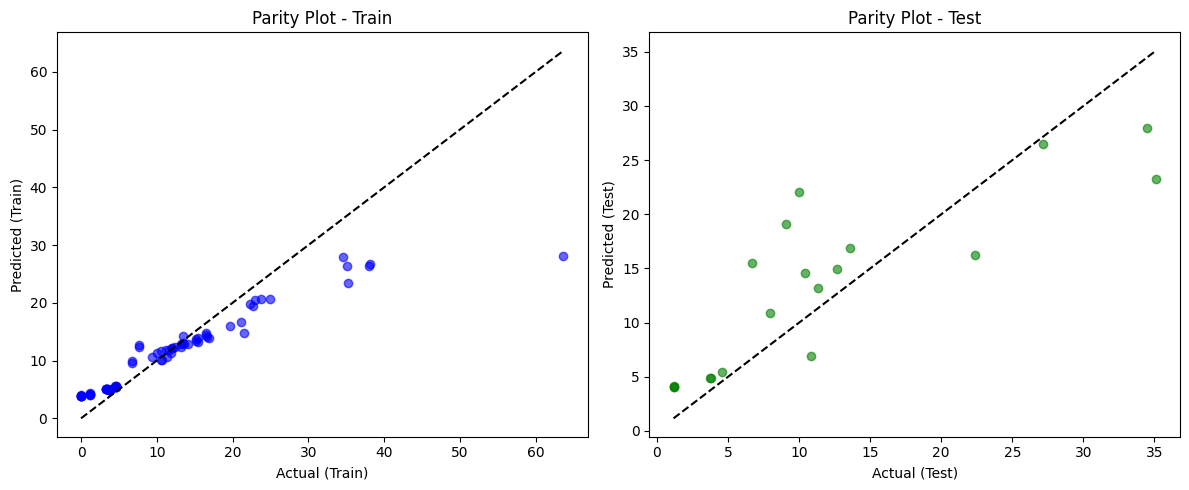

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.xlabel("Actual (Train)")
plt.ylabel("Predicted (Train)")
plt.title("Parity Plot - Train")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual (Test)")
plt.ylabel("Predicted (Test)")
plt.title("Parity Plot - Test")

plt.tight_layout()
plt.show()


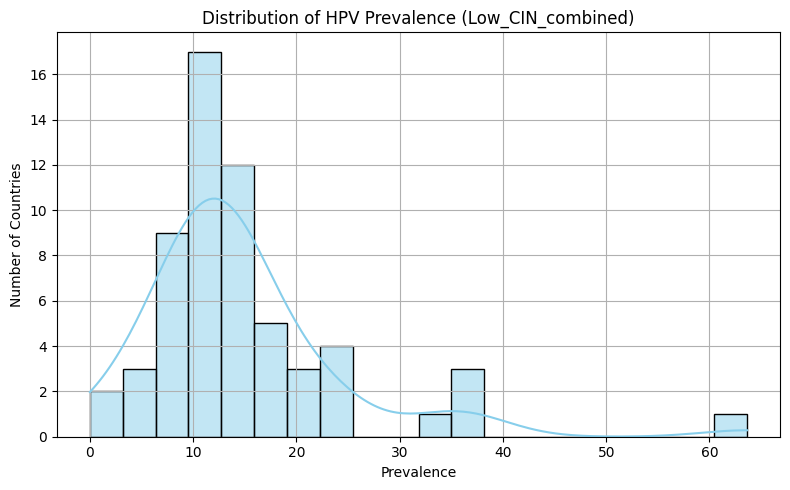

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Low_CIN_combined"], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of HPV Prevalence (Low_CIN_combined)")
plt.xlabel("Prevalence")
plt.ylabel("Number of Countries")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Reuse existing settings
circumcision_col = "Male circumcision (WHO 2007)"
disease_cols = ["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"]
sti_cols = [
    'STI_SyphilisRate_rateper100k_2021',
    'STI_ChlamydialInfectionRate_rateper100k_2021',
    'STDRates_GonococcalInfectionRate_rateper100k_2021'
]

# Function to convert screening year
def convert_screening_year(value):
    if pd.isnull(value): return np.nan
    if isinstance(value, str) and value.strip().lower() in ["not started", "unknown"]:
        return 0
    try: return int(value)
    except: return np.nan

# Load the full dataset again
df_full = pd.read_excel('/content/deduplicated_by_mode.xlsx')

# Drop unnecessary columns
columns_to_drop = [
    "Continent", "NCC-16-cases", "NCC-18-cases", "Low CIN-16-cases", "Low CIN-18-cases",
    "High CIN-16-cases", "High CIN-18-cases", "ICC - 16 - any - cases", "ICC - 16 - SCC - cases",
    "ICC - 16 - ADC - cases", "ICC - 18 - any - cases", "ICC - 18 - SCC - cases",
    "ICC - 18 - ADC - cases", 'Sample size studied', 'ICC prevalence',
    'High CIN prevalence', 'Low CIN prevalence'
]
df_full.drop(columns=columns_to_drop, errors='ignore', inplace=True)

# Derived features
df_full["TB_Incidence_Percent"] = (df_full["Incidence of TB"] / df_full["Population estimate"]) * 100
df_norm_full = df_full[disease_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_full["Disease_Incidence_Score"] = df_norm_full.mean(axis=1)
df_full.drop(columns=disease_cols, inplace=True)

# Screening year conversion
df_full["Screening_Start_Year"] = df_full["Start of Screening coverage (year)"].apply(convert_screening_year)

# Male circumcision category
if circumcision_col in df_full.columns:
    df_full["Male circumcision category"] = df_full[circumcision_col].map({"<20": "Low", "20-80": "Medium", ">80": "High"})
    df_full.drop(columns=[circumcision_col], inplace=True)

# STI Score
df_sti_norm_full = df_full[sti_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_full['STI_Score'] = df_sti_norm_full.mean(axis=1)
df_full.drop(columns=sti_cols, inplace=True)

# Target column (only available for knowns)
df_full['Low_CIN_combined'] = df_full[['Low CIN-16-prevalence', 'Low CIN-18-prevalence']].mean(axis=1, skipna=True)

# Save country and true value (for reference)
df_pred_output = df_full[["Country", "Low_CIN_combined"]].copy()

# Drop other target-related columns
df_full.drop(columns=[
    "NCC-16-prevalence", "NCC-18-prevalence", "Low CIN-16-prevalence", "Low CIN-18-prevalence",
    "High CIN-16-prevalence", "High CIN-18-prevalence", "ICC - 16 - any - prevalence",
    "ICC - 16 - SCC - prevalence", "ICC - 16 - ADC - prevalence", "ICC - 18 - any - prevalence",
    "ICC - 18 - SCC - prevalence", "ICC - 18 - ADC - prevalence", "Start of Screening coverage (year)"
], inplace=True, errors='ignore')

# === Prepare Features for Prediction ===
X_all_full = df_full.drop(columns=['Low_CIN_combined', 'Country', 'economy'], errors='ignore')
X_all_encoded = pd.get_dummies(X_all_full, drop_first=True)
X_all_encoded_imputed = imputer.transform(X_all_encoded)
X_all_selected = pd.DataFrame(X_all_encoded_imputed, columns=X_all_encoded.columns)[selected_features]

# === Predict ===
y_all_predicted = final_model.predict(X_all_selected)
df_pred_output["Predicted_Low_CIN_combined"] = y_all_predicted

# Save to Excel
output_path = "/content/Low_CIN_combined.xlsx"
df_pred_output.to_excel(output_path, index=False)
print(f"✅ Predictions saved to: {output_path}")

# OPTIONAL: Download in Colab
try:
    from google.colab import files
    files.download(output_path)
except:
    print("ℹ️ Skipping download — not running in Colab or `files` not available.")

# OPTIONAL: Show top unknown predictions
df_unknown = df_pred_output[df_pred_output["Low_CIN_combined"].isna()]
print("\n📌 Top Unknown Predictions:")
print(df_unknown[["Country", "Predicted_Low_CIN_combined"]].sort_values(by="Predicted_Low_CIN_combined", ascending=False).head(10))


✅ Predictions saved to: /content/Low_CIN_combined.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📌 Top Unknown Predictions:
             Country  Predicted_Low_CIN_combined
65             Ghana                   21.490328
72             Haiti                   21.034807
132           Panama                   20.184137
40        Costa Rica                   19.369455
152       Seychelles                   18.591406
157  Solomon Islands                   18.548374
63           Georgia                   18.489283
31        Cape Verde                   18.192972
172             Togo                   17.983328
39      Cook Islands                   17.952747


In [ ]:
pip install plotly


In [ ]:
import plotly.express as px

# Create a copy and rename for clarity
df_map = df_pred_output.copy()

# Replace missing predicted values (just in case)
df_map["Prevalence_to_Plot"] = df_map["Predicted_Low_CIN_combined"]

# Plot the choropleth map
fig = px.choropleth(
    df_map,
    locations="Country",
    locationmode="country names",
    color="Prevalence_to_Plot",
    hover_name="Country",
    color_continuous_scale="Reds",
    title="🌍 Predicted High-CIN Prevalence by Country (HPV)",
    labels={"Prevalence_to_Plot": "Predicted Prevalence"},
    template="plotly_white"
)

# Update layout for better view
fig.update_geos(
    projection_type="natural earth",
    showcoastlines=True,
    showcountries=True,
    showland=True,
    landcolor="lightgray"
)
fig.update_layout(
    coloraxis_colorbar=dict(title="Prevalence"),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()
